In [1]:
from cryptocmd import CmcScraper
import pandas as pd
import coinmarketcappy as cmc
from matplotlib import pyplot as plt
import seaborn as sns
import json
import requests
from bs4 import BeautifulSoup
import csv
import sys

In [2]:
Debug = True #Make it False for fetching data first time
def CoinNames():
    """Gets ID's of all coins on cmc"""

    names = []
    response = requests.get("https://api.coinmarketcap.com/v1/ticker/?limit=0")
    respJSON = json.loads(response.text)
    for i in respJSON:
        if float(i['rank']) <=500:
            names.append(i['id'])
    return names

def gather(startdate, enddate, names):
    historicaldata = []
    counter = 1

    if len(names) == 0:
        names = CoinNames()

    for coin in names:
        r  = requests.get("https://coinmarketcap.com/currencies/{0}/historical-data/?start={1}&end={2}".format(coin, startdate, enddate))
        data = r.text
        soup = BeautifulSoup(data, "html.parser")
        table = soup.find('table', attrs={ "class" : "table"})

        #Add table header to list
        if len(historicaldata) == 0:
            headers = [header.text for header in table.find_all('th')]
            headers.insert(0, "Coin")

        for row in table.find_all('tr'):
            currentrow = [val.text for val in row.find_all('td')]
            if(len(currentrow) != 0):
                currentrow.insert(0, coin)
            historicaldata.append(currentrow)

        print("Coin Counter -> " + str(counter), end='\r')
        counter += 1
    return headers, historicaldata

if Debug is False:
    data = gather('20170701', '20180701', [])
    df = pd.DataFrame(list(data[1][1:]), columns=['Coin', 'Date', 'Open*', 'High', 'Low', 'Close', 'Volume', 'Market Cap'])  
    df.to_csv('coindata.csv')

df = pd.read_csv('coindata.csv', thousands=',')
df.head()

,Unnamed: 0,Coin,Date,Open*,High,Low,Close,Volume,Market Cap
0,0,bitcoin,"Jul 01, 2018",6411.68,6432.85,6289.29,6385.82,4.788260e+09,"109,797,000,000"
1,1,bitcoin,"Jun 30, 2018",6214.22,6465.51,6214.22,6404.00,4.543860e+09,"106,405,000,000"
2,2,bitcoin,"Jun 29, 2018",5898.13,6261.66,5835.75,6218.30,3.966230e+09,"100,981,000,000"
3,3,bitcoin,"Jun 28, 2018",6153.16,6170.41,5873.05,5903.44,3.467800e+09,"105,336,000,000"
4,4,bitcoin,"Jun 27, 2018",6084.40,6180.00,6052.85,6157.13,3.296220e+09,"104,149,000,000"


In [3]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Market Cap'] = df['Market Cap'].str.replace(',', '')
df['Market Cap'] = pd.to_numeric(df['Market Cap'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.head()

,Unnamed: 0,Coin,Date,Open*,High,Low,Close,Volume,Market Cap
0,0,bitcoin,2018-07-01,6411.68,6432.85,6289.29,6385.82,4.788260e+09,1.097970e+11
1,1,bitcoin,2018-06-30,6214.22,6465.51,6214.22,6404.00,4.543860e+09,1.064050e+11
2,2,bitcoin,2018-06-29,5898.13,6261.66,5835.75,6218.30,3.966230e+09,1.009810e+11
3,3,bitcoin,2018-06-28,6153.16,6170.41,5873.05,5903.44,3.467800e+09,1.053360e+11
4,4,bitcoin,2018-06-27,6084.40,6180.00,6052.85,6157.13,3.296220e+09,1.041490e+11


In [4]:
df_pivot = df[df['Date'] > '2016-06-22'].pivot(index='Date', columns='Coin', values='Market Cap').sort_index()
df_pivot.head()
df.head()

,Unnamed: 0,Coin,Date,Open*,High,Low,Close,Volume,Market Cap
0,0,bitcoin,2018-07-01,6411.68,6432.85,6289.29,6385.82,4.788260e+09,1.097970e+11
1,1,bitcoin,2018-06-30,6214.22,6465.51,6214.22,6404.00,4.543860e+09,1.064050e+11
2,2,bitcoin,2018-06-29,5898.13,6261.66,5835.75,6218.30,3.966230e+09,1.009810e+11
3,3,bitcoin,2018-06-28,6153.16,6170.41,5873.05,5903.44,3.467800e+09,1.053360e+11
4,4,bitcoin,2018-06-27,6084.40,6180.00,6052.85,6157.13,3.296220e+09,1.041490e+11


In [5]:
marketcap_coins = pd.DataFrame(df[df['Date']=='2018-06-20'].set_index('Coin')['Market Cap']).sort_values(by='Market Cap', ascending=False)

In [6]:
# Total Market Capitalization
market_cap = cmc.total_market_cap(exclude_btc=False)
market_cap_dict = {'Date':[], "Market Cap": []}
for value in market_cap['market_cap_by_available_supply']:
    market_cap_dict['Date'].append(value[0])
    market_cap_dict['Market Cap'].append(value[1])

market_cap_df = pd.DataFrame(market_cap_dict)
market_cap_df['Date'] = pd.to_datetime(market_cap_df['Date']).dt.date
market_cap_df = market_cap_df.set_index('Date')

In [7]:
longer_than_120_coins = []

for coin in df_pivot.count().index:
    if df_pivot.count()[coin] > 200:
        longer_than_120_coins.append(coin)

marketcap_coins_longer_120 = marketcap_coins[marketcap_coins.index.isin(longer_than_120_coins)]

top_200_coins = []

for i in range(0,200):
    top_200_coins.append(marketcap_coins_longer_120.index[i])

In [8]:
# Function to get the market cap for the rest of the market
def calc_market_cap_minus_coin_corr(coin, df1, df2):
    temp_df = pd.DataFrame(df1[coin]).join(df2)
    temp_df['Market Cap'] = temp_df['Market Cap'] - temp_df[coin]
    return temp_df.corr()['Market Cap'][0]

df_dict = {}

for coin in top_200_coins:
    df_dict[coin] = calc_market_cap_minus_coin_corr(coin, df_pivot, market_cap_df)

Text(0,0.5,'Density')

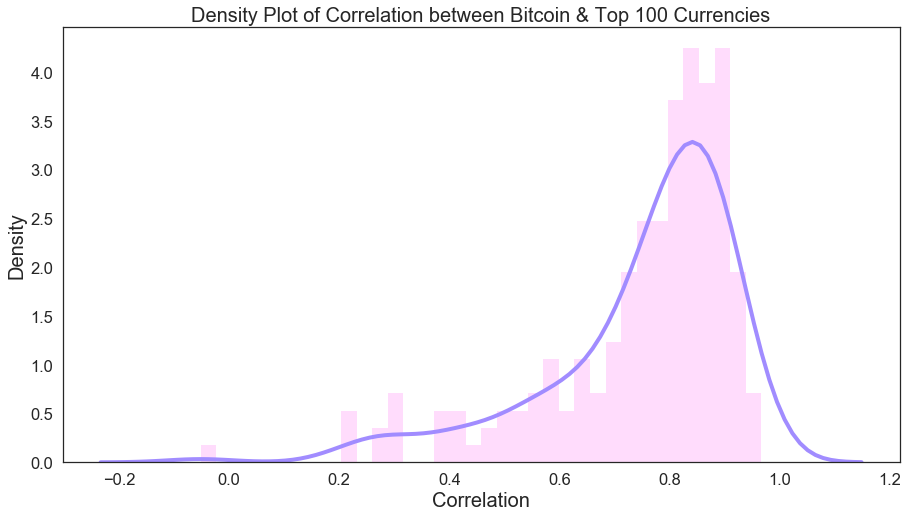

In [9]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style("white")
ax = sns.distplot(list(df_dict.values()), hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'none', "color": "#ffa8f9" , "alpha":0.4},
             kde_kws={'linewidth': 4, 'color': '#a18cff'})
ax.grid(False)
ax.axes.set_title("Density Plot of Correlation between Bitcoin & Top 100 Currencies",fontsize=20)
ax.set_xlabel("Correlation",fontsize=20)
ax.set_ylabel("Density",fontsize=20)

In [10]:
s = pd.DataFrame({'coin' : list(df_dict.keys()), 'correlation': list(df_dict.values())})


In [21]:
s.sort_values(['correlation'])[0:10].style.background_gradient(cmap='RdBu')

,coin,correlation
111,metal,-0.0511862
156,kickico,0.212548
35,rchain,0.22117
92,iconomi,0.228339
161,minexcoin,0.275162
118,genesis-vision,0.276127
94,tenx,0.298897
164,mobilego,0.300084
102,gnosis-gno,0.303716
165,prizm,0.308345
